In [2]:
%run -m ipy_startup
%matplotlib inline
%load_ext rpy2.ipython
from ml import query
from pbto2 import data, prep

In [1192]:
# Good results:

# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = .25
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 300, 800, np.inf]
# interp = '4'
# allow_gos_interp = True

# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 30, 100, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [1210]:
max_hours = 48
time = 'tsi_min'
pbto2_thresh = 8 / max_hours
agg_mode = 'pct'
pbto2_bins = [0, 20, 100, np.inf]
pao2_bins = [0, 30, 100, np.inf]
icp_bins = [0, 20, np.inf]
pha_bins = [0, 7.35, 7.45, np.inf]
paco2_bins = [0, 35, 45, np.inf]
interp = 'none'
allow_gos_interp = True

d = data.get_raw_data(f='data_clean_interp_{}.pkl'.format(interp))

# Multiply pao2 values by constant
d['pao2'] = d['pao2'] * .4

# This patient has an excessively long string of consecutive 0 pbto2 values after this tsa_min value
# (so remove the unnecessary measurements)
d = d[(d['uid'] != 1001) | (d['tsa_min'] <= 1320)]

def plot_ts(d, col, uids, figsize=(12,6), ylim=None):
    df = d[d['uid'].isin(uids)][['tsa_min', col, 'uid']]
    ax = df.pivot_table(index='tsa_min', columns='uid', values=col).plot(figsize=figsize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
# Limit to only some subset of early measurments
d = d[d[time] <= max_hours * 60]

# Remove patients that don't have enough measurments within the early subset
ct = d.groupby('uid').apply(lambda x: len(x['pbto2'].dropna()) / max_hours)
#ct.hist()
rm_uids = ct[ct < pbto2_thresh].index.values
d = d[~d['uid'].isin(rm_uids)]

# Set gos response column, using interpolation if enabled
if allow_gos_interp:
    d['gos'] = d.apply(lambda x: x['gos-3'] if not pd.isnull(x['gos-3']) else x['gos-6'], axis=1)
else:
    d['gos'] = d['gos-3']

In [1194]:
#d.paco2.hist(bins=50)

In [1195]:
# uids = d[d['pbto2'] <= 0].groupby('uid').size()
# uids = uids[uids > 6].index.values
# plot_ts(d, 'pbto2', uids)

In [1196]:
# uids = d['uid'].unique()
# uids = uids[np.random.permutation(np.arange(len(uids)))[:10]]
# plot_ts(d, 'pao2', uids)

In [1211]:
def get_features(x):
    def bin_values(v, bins, prefix, mode='count'):
        assert mode in ['count', 'mean', 'pct'], 'Mode {} is not valid'.format(mode)
        labels = ['{}_{}_{}'.format(prefix, bins[i-1], bins[i]) for i in range(1, len(bins))]
        ct = pd.cut(v, bins=bins, include_lowest=True, right=False, labels=labels)
        if mode == 'count':
            ct = ct.value_counts()
        elif mode == 'pct':
            ct = ct.value_counts()
            ct = ct if ct.sum() == 0 else ct / ct.sum()
        elif mode == 'mean':
            ct = v.groupby(ct).mean()
        return ct.to_dict()
    
    r = {}
    r.update(bin_values(x['pbto2'], pbto2_bins, 'pbto2', mode=agg_mode))
    r.update(bin_values(x['pao2'], pao2_bins, 'pao2', mode=agg_mode))
    r.update(bin_values(x['icp1'], icp_bins, 'icp1', mode=agg_mode))
    r.update(bin_values(x['pha'], pha_bins, 'pha', mode=agg_mode))
    r.update(bin_values(x['paco2'], paco2_bins, 'paco2', mode=agg_mode))
#     r['n_pbto2'] = len(x['pbto2'].dropna())
#     r['n_pao2'] = len(x['pao2'].dropna())
#     r['n_icp1'] = len(x['icp1'].dropna())
#     r['n_pha'] = len(x['pha'].dropna())
#     r['n_paco2'] = len(x['paco2'].dropna())
        
    x = x.iloc[0]
    r['gos'] = x['gos']
    r['marshall'] = x['marshall']
    r['gcs'] = x['gcs']
    r['age'] = x['age']
    r['sex'] = x['sex']
    
    return pd.Series(r)
do = d.groupby('uid').apply(get_features)
do = do[~do['gos'].isnull()]
do = do[~do['marshall'].isnull()]
do.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 461 to 1056
Data columns (total 19 columns):
age              268 non-null float64
gcs              268 non-null float64
gos              268 non-null float64
icp1_0_20        268 non-null float64
icp1_20_inf      268 non-null float64
marshall         268 non-null float64
paco2_0_35       268 non-null float64
paco2_35_45      268 non-null float64
paco2_45_inf     268 non-null float64
pao2_0_30        268 non-null float64
pao2_100_inf     268 non-null float64
pao2_30_100      268 non-null float64
pbto2_0_20       268 non-null float64
pbto2_100_inf    268 non-null float64
pbto2_20_100     268 non-null float64
pha_0_7.35       268 non-null float64
pha_7.35_7.45    268 non-null float64
pha_7.45_inf     268 non-null float64
sex              268 non-null float64
dtypes: float64(19)
memory usage: 41.9 KB


In [1216]:
#do.to_csv('/Users/eczech/data/pbto2/export/data_modeling.csv', index=False)
d_exp = d[d['uid'].isin(do.index.values)]
d_exp.to_csv('/Users/eczech/data/pbto2/export/data_stan_input.csv', index=False)

In [1218]:
d_exp[d_exp['pbto2'].isnull()]

,uid,datetime,pbto2,pao2,pha,icp1,paco2,map,bo2,birthdate,...,tsi,tsa,tsi_min,tsa_min,marshall,gos-12,gos-24,gos-3,gos-6,gos
31074,534,2003-08-27 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,31.4,1978-05-14,...,13:00:00,0 days,780,0,2,3,NaN,3,3,3


In [1206]:
do.describe()

,age,gcs,gos,icp1_0_20,icp1_20_inf,marshall,paco2_0_35,paco2_35_45,paco2_45_inf,pao2_0_30,pao2_100_inf,pao2_30_100,pbto2_0_20,pbto2_100_inf,pbto2_20_100,pha_0_7.35,pha_7.35_7.45,pha_7.45_inf,sex
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,37.705224,5.888060,2.735075,0.579579,0.043555,3.052239,0.471788,0.492550,0.031931,0.027332,0.067346,0.901591,0.313504,0.002742,0.683754,0.084388,0.634929,0.276952,0.768657
std,16.286263,1.467043,1.199548,0.469347,0.132368,1.462731,0.310014,0.296203,0.098684,0.078882,0.147622,0.169339,0.323366,0.017864,0.322236,0.176621,0.277633,0.279998,0.422480
min,16.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,5.000000,1.000000,0.000000,0.000000,2.000000,0.241260,0.233333,0.000000,0.000000,0.000000,0.870331,0.041229,0.000000,0.534139,0.000000,0.461197,0.025987,1.000000
50%,34.000000,6.000000,3.000000,0.911438,0.000000,2.000000,0.444444,0.500000,0.000000,0.000000,0.000000,0.975305,0.213203,0.000000,0.786797,0.000000,0.680815,0.209707,1.000000
75%,49.000000,7.000000,4.000000,1.000000,0.000000,4.000000,0.730224,0.695076,0.000000,0.000000,0.074306,1.000000,0.454781,0.000000,0.951510,0.074786,0.858135,0.436166,1.000000
max,77.000000,8.000000,5.000000,1.000000,1.000000,6.000000,1.000000,1.000000,0.846154,0.666667,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1207]:
#do.plot(kind='scatter', x='n_pbto2', y='gos')

In [1208]:
%%R -i do
library(dplyr)
library(MASS)
scale <- function(x) (x - mean(x)) / sd(x)
d <- do %>% mutate_each(funs(as.numeric)) %>%
    mutate_each(funs(scale), -gos) %>%
    #dplyr::select(-pao2_300_800, -pbto2_20_100, -starts_with('n_'), -starts_with('pao2'))
    dplyr::select(-paco2_35_45, -icp1_0_20, -pha_7.35_7.45, -pao2_30_100, -pbto2_20_100, -starts_with('n_'))

In [1151]:
%%R 
res <- d %>% mutate(gos = ifelse(gos <= 3, 0, 1)) %>%
    glm(gos ~ ., data=., family='binomial')
summary(res)


Call:
glm(formula = gos ~ ., family = "binomial", data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2112  -0.7386  -0.4278   0.4293   2.4207  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.6092     0.2217  -7.258 3.92e-13 ***
age            -0.7259     0.2023  -3.587 0.000334 ***
gcs             0.5320     0.1857   2.864 0.004181 ** 
icp1_20_inf    -0.6440     0.3239  -1.989 0.046752 *  
marshall       -0.3524     0.1942  -1.814 0.069638 .  
paco2_0_35     -0.1095     0.1943  -0.564 0.572983    
paco2_45_inf    0.3859     0.2255   1.711 0.087077 .  
pao2_0_30      -0.7626     0.3447  -2.212 0.026943 *  
pao2_100_inf   -0.1473     0.1751  -0.841 0.400275    
pbto2_0_20     -0.2346     0.1808  -1.298 0.194452    
pbto2_100_inf  -0.9017     0.6208  -1.453 0.146342    
pha_0_7.35     -0.1639     0.1932  -0.848 0.396246    
pha_7.45_inf   -0.4447     0.2156  -2.063 0.039123 *  
sex             0.3048     0.1935   1.57

In [1152]:
%%R
get.polr.coefs <- function(m){
    coefs <- coef(summary(m))
    p <- pnorm(abs(coefs[, "t value"]), lower.tail = FALSE) * 2
    coefs <- cbind(coefs, "p value" = p)
    coefs
}
m <- d %>% 
    mutate(gos=factor(gos, levels=1:5, labels=c('Dead', 'Bad1', 'Bad2', 'Good1', 'Good2'))) %>%
    polr(gos ~ ., data = ., Hess=TRUE)
print(summary(m))
get.polr.coefs(m)

Call:
polr(formula = gos ~ ., data = ., Hess = TRUE)

Coefficients:
                Value Std. Error t value
age           -0.9729     0.1481 -6.5710
gcs            0.6893     0.1339  5.1463
icp1_20_inf   -0.4965     0.1676 -2.9618
marshall      -0.3050     0.1380 -2.2095
paco2_0_35    -0.1597     0.1371 -1.1642
paco2_45_inf   0.4392     0.1641  2.6760
pao2_0_30     -0.2488     0.1198 -2.0778
pao2_100_inf  -0.1846     0.1255 -1.4709
pbto2_0_20    -0.1608     0.1267 -1.2691
pbto2_100_inf -0.1283     0.1176 -1.0915
pha_0_7.35    -0.1468     0.1472 -0.9971
pha_7.45_inf  -0.2773     0.1379 -2.0104
sex            0.1857     0.1305  1.4234

Intercepts:
            Value   Std. Error t value
Dead|Bad1   -1.3815  0.1693    -8.1620
Bad1|Bad2   -1.0375  0.1594    -6.5082
Bad2|Good1   1.5687  0.1747     8.9786
Good1|Good2  3.7355  0.3159    11.8255

Residual Deviance: 592.5141 
AIC: 626.5141 
                   Value Std. Error   t value      p value
age           -0.9729214  0.1480618 -6.571049 

In [1153]:
%%R
m <- d %>% 
    mutate(gos=ifelse(gos==1, 0, ifelse(gos <= 3, 1, 2))) %>%
    mutate(gos=factor(gos, levels=1:3, labels=c('Dead', 'Bad', 'Good'))) %>%
    polr(gos ~ ., data = ., Hess=TRUE)
print(summary(m))
get.polr.coefs(m)

Call:
polr(formula = gos ~ ., data = ., Hess = TRUE)

Coefficients:
                 Value Std. Error t value
age           -0.39266     0.2208 -1.7780
gcs            0.36341     0.1919  1.8941
icp1_20_inf   -0.55704     0.3473 -1.6038
marshall      -0.32836     0.1975 -1.6622
paco2_0_35    -0.11203     0.2084 -0.5375
paco2_45_inf   0.26140     0.2249  1.1621
pao2_0_30     -0.77566     0.3494 -2.2201
pao2_100_inf  -0.07828     0.1836 -0.4263
pbto2_0_20    -0.27370     0.1892 -1.4464
pbto2_100_inf -0.90275     0.6316 -1.4292
pha_0_7.35    -0.05644     0.2111 -0.2674
pha_7.45_inf  -0.38630     0.2198 -1.7572
sex            0.27179     0.1975  1.3760

Intercepts:
         Value    Std. Error t value 
Dead|Bad   1.2168   0.2330     5.2212
Bad|Good  47.3939   0.2330   203.3681

Residual Deviance: 217.2206 
AIC: 247.2206 
(70 observations deleted due to missingness)
                    Value Std. Error     t value      p value
age           -0.39265883  0.2208476  -1.7779628 7.540996e-02
gcs

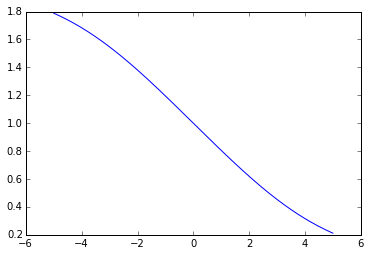

In [7]:
import math
x = np.linspace(-5, 5, 1000)

a1, a2 = 1, 1
b1, b2 = .5, .5
c1, c2 = -2, 2
def f1(x):
    return a1 / (1 + np.exp(b1*(x - c1)))
def f2(x):
    return a2 / (1 + np.exp(b2*(x - c2)))
fl1 = np.vectorize(f1)
fl2 = np.vectorize(f2)

y = (fl1(x) + fl2(x))
#y = .5 * fl1(x)
plt.plot(x, y)